# Facial Expression Recognizer

In [7]:
#The OS module in Python provides a way of using operating system dependent functionality. 
#import os
# For array manipulation
import numpy as np 
#For importing data from csv and other manipulation
import pandas as pd

#For displaying images
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

#For displaying graph
#import seaborn as sns

#For constructing and handling neural network
import tensorflow as tf

#Constants
LEARNING_RATE = 1e-4
TRAINING_ITERATIONS = 10000 #increase iteration to improve accuracy           
DROPOUT = 0.5
BATCH_SIZE = 50
IMAGE_TO_DISPLAY = 3
VALIDATION_SIZE = 2000

In [8]:
#Reading data from csv file
data = pd.read_csv('Train_updated_six_emotion.csv')

#Seperating images data from labels ie emotion
images = data.iloc[:,1:].values
images = images.astype(np.float)

#Normalizaton : convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

image_size = images.shape[1]
image_width = image_height = 48



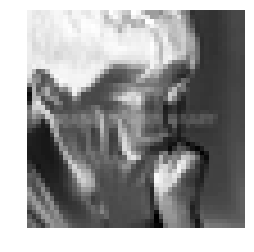

In [9]:
#Displaying an image from 20K images
def display(img):
    #Reshaping,(1*2304) pixels into (48*48)
    one_image = img.reshape(image_width,image_height)
    plt.axis('off')
    #Show image
    plt.imshow(one_image, cmap=cm.binary)     
display(images[IMAGE_TO_DISPLAY])

In [10]:
#Creating an array of emotion labels using dataframe 'data'
labels_flat = data[['label']].values.ravel()

labels_count = np.unique(labels_flat).shape[0]

# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0]
# 1 => [0 1 0]
# 2 => [0 0 1]
def dense_to_one_hot(labels_dense, num_classes = 7):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

#Printing example  hot-dense label
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels[3] => [0 0 0 0 1 0]


In [11]:
#Using data for training & cross validation
validation_images = images[:2000]
validation_labels = labels[:2000]

train_images = images[2000:]
train_labels = labels[2000:]




#Next is the neural network structure.
#Weights and biases are created.
#The weights should be initialised with a small a amount of noise
#for symmetry breaking, and to prevent 0 gradients. Since we are using
#rectified neurones (ones that contain rectifier function *f(x)=max(0,x)*),
#we initialise them with a slightly positive initial bias to avoid "dead neurones.

In [12]:
# initialization of weight
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)



# We use zero padded convolution neural network with a stride of 1 and the size of the output is same as that of input.
# The convolution layer finds the features in the data the number of filter denoting the number of features to be detected.
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Pooling downsamples the data. 2x2 max-pooling splits the image into square 2-pixel blocks and only keeps the maximum value 
# for each of the blocks. 
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [13]:
# images
x = tf.placeholder('float', shape=[None, image_size])

# labels (0, 1 or 2)
y_ = tf.placeholder('float', shape=[None, labels_count])


In [14]:
BATCH_SIZE

50

### VGG-16 architecture

In [15]:
W_conv1 = weight_variable([3, 3, 1, 8])
b_conv1 = bias_variable([8])


# we reshape the input data to a 4d tensor, with the first dimension corresponding to the number of images,
# second and third - to image width and height, and the final dimension - to the number of colour channels.
# (20000,2304) => (20000,48,48,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
print (image.get_shape()) 

h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
print (h_conv1)



W_conv2 = weight_variable([3, 3, 8, 8])
b_conv2 = bias_variable([8])
h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)

print (h_conv2)
# pooling reduces the size of the output from 48x48 to 24x24.
h_pool1 = max_pool_2x2(h_conv2)
#print (h_pool1.get_shape()) => (20000, 24, 24, 8)

# Prepare for visualization
# display 8 features in 4 by 2 grid
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,2))  

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))
layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*2))



# The second layer has 16 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 8, 16].
# The first two dimensions are the patch size. the next is the number of input channels (8 channels correspond to 8
# features that we got from previous convolutional layer).

W_conv3 = weight_variable([3, 3, 8, 16])
b_conv3 = bias_variable([16])
h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv3) + b_conv3)
print(h_conv3)

W_conv4 = weight_variable([3, 3, 16, 16])
b_conv4 = bias_variable([16])
h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4) + b_conv4)
print(h_conv4)

h_pool2 = max_pool_2x2(h_conv4)
#print (h_pool2.get_shape()) => (20000, 12, 12, 16)

# The third layer has 16 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 16, 32].
# The first two dimensions are the patch size. the next is the number of input channels (16 channels correspond to 16
# features that we got from previous convolutional layer)
W_conv5 = weight_variable([3, 3, 16, 32])
b_conv5 = bias_variable([32])
h_conv5 = tf.nn.relu(conv2d(h_pool2, W_conv5) + b_conv5)
print(h_conv5)


W_conv6 = weight_variable([3, 3, 32, 32])
b_conv6 = bias_variable([32])
h_conv6 = tf.nn.relu(conv2d(h_conv5, W_conv6) + b_conv6)
print(h_conv6)

W_conv7 = weight_variable([3, 3, 32, 32])
b_conv7 = bias_variable([32])
h_conv7 = tf.nn.relu(conv2d(h_conv6, W_conv7) + b_conv7)
print(h_conv7)

h_pool3 = max_pool_2x2(h_conv7)
#print (h_pool2.get_shape()) => (20000, 6, 6, 32)


W_conv8 = weight_variable([3, 3, 32, 32])
b_conv8 = bias_variable([32])
h_conv8 = tf.nn.relu(conv2d(h_pool3, W_conv8) + b_conv8)
print(h_conv8)


W_conv9 = weight_variable([3, 3, 32, 32])
b_conv9 = bias_variable([32])
h_conv9 = tf.nn.relu(conv2d(h_conv8, W_conv9) + b_conv9)
print(h_conv9)

W_conv10 = weight_variable([3, 3, 32, 32])
b_conv10 = bias_variable([32])
h_conv10 = tf.nn.relu(conv2d(h_conv9, W_conv10) + b_conv10)
print(h_conv10)


h_pool4 = max_pool_2x2(h_conv10)
print (h_pool4.get_shape())
# Now that the image size is reduced to 3x3, we add a Fully_Connected_layer) with 1024 neurones
# to allow processing on the entire image (each of the neurons of the fully connected layer is 
# connected to all the activations/outpus of the previous layer)

W_conv11 = weight_variable([3, 3, 32, 32])
b_conv11 = bias_variable([32])
h_conv11 = tf.nn.relu(conv2d(h_pool4, W_conv11) + b_conv11)
print(h_conv11)

W_conv12 = weight_variable([3, 3, 32, 32])
b_conv12 = bias_variable([32])
h_conv12 = tf.nn.relu(conv2d(h_conv11, W_conv12) + b_conv12)
print(h_conv12)

W_conv13 = weight_variable([3, 3, 32, 32])
b_conv13 = bias_variable([32])
h_conv13 = tf.nn.relu(conv2d(h_conv12, W_conv13) + b_conv13)
print(h_conv13)



# densely connected layer
W_fc1 = weight_variable([3 * 3 * 32, 512])
b_fc1 = bias_variable([512])

# (20000, 6, 6, 32) => (20000, 1152 )
h_pool2_flat = tf.reshape(h_conv13, [-1, 3*3*32])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
print (h_fc1.get_shape()) # => (20000, 1024)

W_fc2 = weight_variable([512, 512])
b_fc2 = bias_variable([512])


h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
print (h_fc2.get_shape()) # => (20000, 1024)

W_fc3 = weight_variable([512, 512])
b_fc3 = bias_variable([512])


h_fc3 = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3)
print (h_fc3.get_shape()) # => (20000, 1024)

# To prevent overfitting, we  apply dropout before the readout layer.
# Dropout removes some nodes from the network at each training stage. Each of the nodes is either kept in the
# network with probability (keep_prob) or dropped with probability (1 - keep_prob).After the training stage 
# is over the nodes are returned to the NN with their original weights.
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer 1024*3
W_fc4 = weight_variable([512, labels_count])
b_fc4 = bias_variable([labels_count])

# Finally, we add a softmax layer
y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc4) + b_fc4)
#print (y.get_shape()) # => (20000, 3)


cross_entropy = -tf.reduce_sum(y_*tf.log(y))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
predict = tf.argmax(y,1)



(?, 48, 48, 1)
Tensor("Relu:0", shape=(?, 48, 48, 8), dtype=float32)
Tensor("Relu_1:0", shape=(?, 48, 48, 8), dtype=float32)
Tensor("Relu_2:0", shape=(?, 24, 24, 16), dtype=float32)
Tensor("Relu_3:0", shape=(?, 24, 24, 16), dtype=float32)
Tensor("Relu_4:0", shape=(?, 12, 12, 32), dtype=float32)
Tensor("Relu_5:0", shape=(?, 12, 12, 32), dtype=float32)
Tensor("Relu_6:0", shape=(?, 12, 12, 32), dtype=float32)
Tensor("Relu_7:0", shape=(?, 6, 6, 32), dtype=float32)
Tensor("Relu_8:0", shape=(?, 6, 6, 32), dtype=float32)
Tensor("Relu_9:0", shape=(?, 6, 6, 32), dtype=float32)
(?, 3, 3, 32)
Tensor("Relu_10:0", shape=(?, 3, 3, 32), dtype=float32)
Tensor("Relu_11:0", shape=(?, 3, 3, 32), dtype=float32)
Tensor("Relu_12:0", shape=(?, 3, 3, 32), dtype=float32)
(?, 512)
(?, 512)
(?, 512)


In [16]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

training_accuracy / validation_accuracy => 0.18 / 0.20 for step 0
training_accuracy / validation_accuracy => 0.18 / 0.20 for step 1
training_accuracy / validation_accuracy => 0.22 / 0.20 for step 2
training_accuracy / validation_accuracy => 0.12 / 0.20 for step 3
training_accuracy / validation_accuracy => 0.20 / 0.20 for step 4
training_accuracy / validation_accuracy => 0.16 / 0.20 for step 5
training_accuracy / validation_accuracy => 0.26 / 0.20 for step 6
training_accuracy / validation_accuracy => 0.12 / 0.20 for step 7
training_accuracy / validation_accuracy => 0.48 / 0.34 for step 8
training_accuracy / validation_accuracy => 0.30 / 0.36 for step 9
training_accuracy / validation_accuracy => 0.30 / 0.36 for step 10
training_accuracy / validation_accuracy => 0.22 / 0.20 for step 20
training_accuracy / validation_accuracy => 0.24 / 0.20 for step 30
training_accuracy / validation_accuracy => 0.22 / 0.20 for step 40
training_accuracy / validation_accuracy => 0.18 / 0.20 for step 50
train

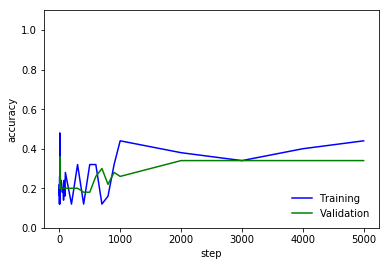

In [17]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # visualisation variables
    train_accuracies = []
    validation_accuracies = []
    x_range = []

    display_step=1

    for i in range(TRAINING_ITERATIONS):

        #get new batch
        batch_xs, batch_ys = next_batch(BATCH_SIZE)        

        # check progress on every 1st,2nd,...,10th,20th,...,100th... step
        if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:

            train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                      y_: batch_ys, 
                                                      keep_prob: 1.0})       
            if(VALIDATION_SIZE):
                validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                                y_: validation_labels[0:BATCH_SIZE], 
                                                                keep_prob: 1.0})                                  
                print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))

                validation_accuracies.append(validation_accuracy)

            else:
                 print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
            train_accuracies.append(train_accuracy)
            x_range.append(i)

            # increase display_step
            if i%(display_step*10) == 0 and i:
                display_step *= 10
        # train on batch
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})
        
        
        
    if(VALIDATION_SIZE):
        validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                       y_: validation_labels, 
                                                       keep_prob: 1.0})
        print('validation_accuracy => %.4f'%validation_accuracy)
        plt.plot(x_range, train_accuracies,'-b', label='Training')
        plt.plot(x_range, validation_accuracies,'-g', label='Validation')
        plt.legend(loc='lower right', frameon=False)
        plt.ylim(ymax = 1.1, ymin = 0.0)
        plt.ylabel('accuracy')
        plt.xlabel('step')
        plt.show()

        
        

   

    
